Bounding Box: (114.16429750153698, 22.323519962243264, 114.16979066559948, 22.328601342406635)
Google Static Map saved to /Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/images/HK/google_static_map.png
Normalized population data saved to /Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/dataset/GGSL_POP/hk_normalized_population.tiff
Overlay image saved to /Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/images/HK/google_static_map_overlay.png


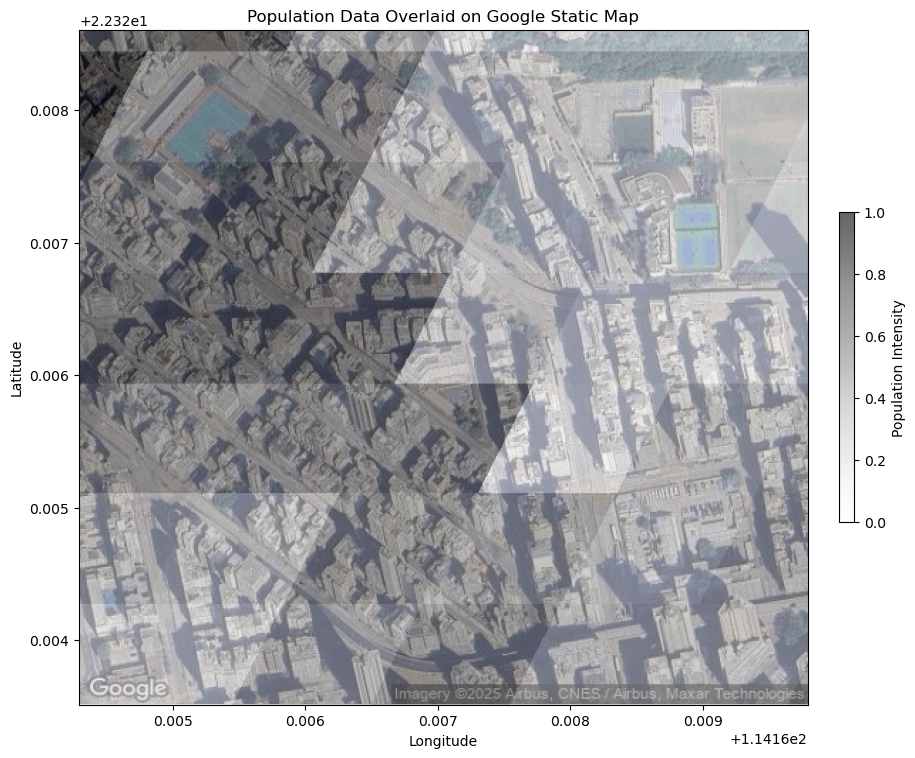

In [18]:
import geopandas as gpd
from shapely.geometry import box
from PIL import Image
from io import BytesIO
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import requests
import math

# Function to calculate bounding box
def get_bounding_box(lat, lon, zoom, size=512):
    EARTH_RADIUS = 6378137.0
    INITIAL_RESOLUTION = 2 * math.pi * EARTH_RADIUS / 256.0  # Resolution at zoom 0
    origin_shift = 2 * math.pi * EARTH_RADIUS / 2.0

    resolution = INITIAL_RESOLUTION / (2 ** zoom)

    mx = lon * origin_shift / 180.0
    my = math.log(math.tan((90 + lat) * math.pi / 360.0)) / (math.pi / 180.0)
    my = my * origin_shift / 180.0

    half_size = (size / 2.0) * resolution
    minx = mx - half_size
    maxx = mx + half_size
    miny = my - half_size
    maxy = my + half_size

    def meters_to_latlon(mx, my):
        lon = (mx / origin_shift) * 180.0
        lat = (my / origin_shift) * 180.0
        lat = 180 / math.pi * (2 * math.atan(math.exp(lat * math.pi / 180.0)) - math.pi / 2.0)
        return lat, lon

    min_lat, min_lon = meters_to_latlon(minx, miny)
    max_lat, max_lon = meters_to_latlon(maxx, maxy)

    return min_lon, min_lat, max_lon, max_lat


# Download Google Static Map
def download_and_crop_static_map(api_key, lat, lon, zoom, output_file, timeout=10, max_retries=3):
    base_url = "https://maps.googleapis.com/maps/api/staticmap"
    params = {
        "center": f"{lat},{lon}",
        "zoom": zoom,
        "size": "512x512",
        "maptype": "satellite",
        "key": api_key,
    }

    for attempt in range(max_retries):
        try:
            response = requests.get(base_url, params=params, timeout=timeout)
            if response.status_code == 200:
                image = Image.open(BytesIO(response.content))
                image.save(output_file)
                print(f"Google Static Map saved to {output_file}")
                return True
        except Exception as e:
            print(f"Error on attempt {attempt + 1}: {e}")
    print(f"Failed to download map after {max_retries} attempts.")
    return False

def overlay_population_and_save(lat, lon, zoom, ghsl_tif_file, api_key, output_image_file, output_tiff_file):
    # Step 1: Calculate bounding box
    bbox = get_bounding_box(lat, lon, zoom)
    min_lon, min_lat, max_lon, max_lat = bbox
    print(f"Bounding Box: {bbox}")

    # Step 2: Download Google Static Map
    success = download_and_crop_static_map(api_key, lat, lon, zoom, output_image_file)
    if not success:
        return

    # Step 3: Open the Google Map image
    google_map = Image.open(output_image_file)

    # Step 4: Read the GHSL population GeoTIFF
    with rasterio.open(ghsl_tif_file) as src:
        population_data = src.read(1)  # Assuming population data is in the first band
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)

    # Normalize the population data for better visualization
    normalized_population = (population_data - np.min(population_data)) / (np.max(population_data) - np.min(population_data))

    # Save the normalized population data as a new TIFF
    with rasterio.open(output_tiff_file, 'w', **src.meta) as dst:
        dst.write(normalized_population, 1)
    print(f"Normalized population data saved to {output_tiff_file}")

    # Step 5: Plot and overlay the population data
    fig, ax = plt.subplots(figsize=(10, 10))
    # Show Google Map
    ax.imshow(google_map, extent=(min_lon, max_lon, min_lat, max_lat), zorder=1)

    # Overlay population data with transparency (alpha)
    img = ax.imshow(
        normalized_population,
        cmap="Greys",  # You can change the colormap if needed
        alpha=0.6,  # Adjust transparency
        extent=extent,
        zorder=2,
    )

    # Add a colorbar for population intensity
    cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)
    cbar.set_label("Population Intensity")

    ax.set_title("Population Data Overlaid on Google Static Map")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # Save the combined overlay image
    overlay_output_file = output_image_file.replace(".png", "_overlay.png")
    plt.savefig(overlay_output_file, dpi=300, bbox_inches="tight")
    print(f"Overlay image saved to {overlay_output_file}")
    plt.show()

# Example Usage
api_key =   # Replace with your Google Maps API key
lat, lon = 22.32606067545809, 114.16704408356823  # Center coordinates
zoom = 17
ghsl_tif_file = "/Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/dataset/GGSL_POP/hk_cropped_ghsl.tiff"
output_image_file = "/Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/images/HK/google_static_map.png"
output_tiff_file = "/Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/dataset/GGSL_POP/hk_normalized_population.tiff"

# Call the function
overlay_population_and_save(lat, lon, zoom, ghsl_tif_file, api_key, output_image_file, output_tiff_file)


#  Without normalizations

TypeError: unsupported operand type(s) for /: 'str' and 'float'

The GeoTIFF is already in EPSG:4326. Skipping reprojection.
Bounding Box: (114.16429750153698, 22.323519962243264, 114.16979066559948, 22.328601342406635)
Google Static Map saved to /Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/images/HK/google_static_map.png
Overlay image saved to /Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/images/HK/google_static_map_overlay.png


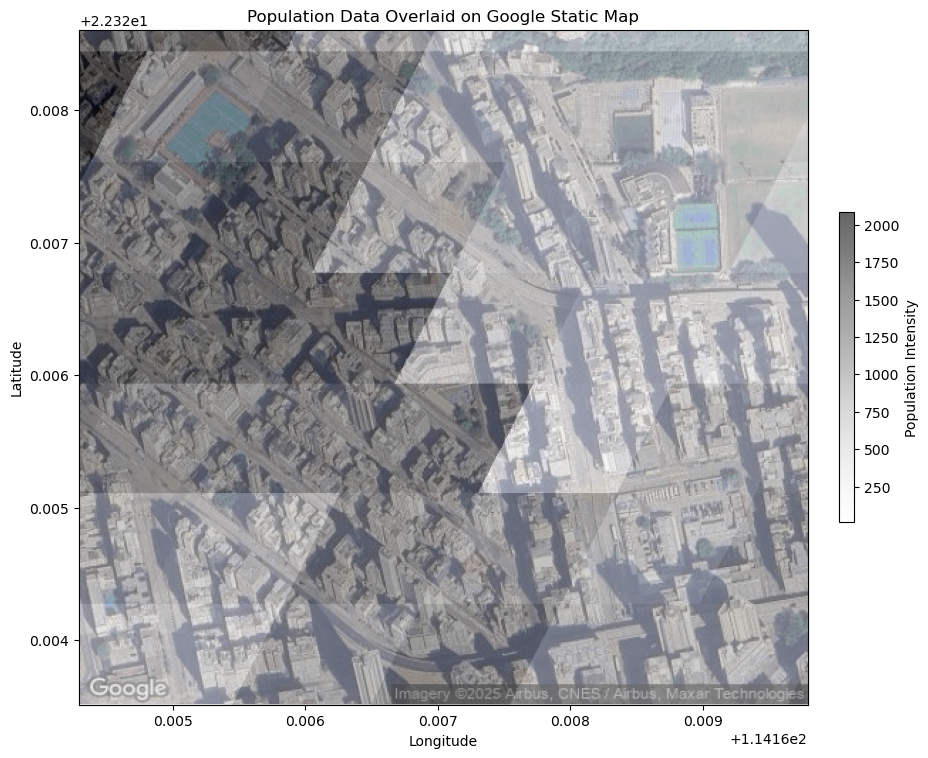

In [2]:
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.enums import Resampling

def overlay_population_and_save(lat, lon, zoom, ghsl_tif_file, api_key, output_image_file, output_tiff_file):
    """
    Overlays population data from a GeoTIFF onto a Google Static Map and saves the result.

    Parameters:
    - lat, lon: Latitude and Longitude of the center point.
    - zoom: Zoom level for the Google Static Map.
    - ghsl_tif_file: Path to the input GeoTIFF file containing population data.
    - api_key: Google Maps API key.
    - output_image_file: Path to save the downloaded Google Static Map image.
    - output_tiff_file: Path to save the reprojected population GeoTIFF (if needed).
    """

    def reproject_to_epsg4326(input_tiff, output_tiff):
        dst_crs = "EPSG:4326"
        with rasterio.open(input_tiff) as src:
            if str(src.crs) == dst_crs:  # Skip reprojection if already in EPSG:4326
                print(f"The GeoTIFF is already in EPSG:4326. Skipping reprojection.")
                return input_tiff

            transform, width, height = calculate_default_transform(
                src.crs, dst_crs, src.width, src.height, *src.bounds
            )
            kwargs = src.meta.copy()
            kwargs.update({
                "crs": dst_crs,
                "transform": transform,
                "width": width,
                "height": height,
            })

            with rasterio.open(output_tiff, "w", **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest,
                    )
        print(f"Reprojected GeoTIFF saved to {output_tiff}")
        return output_tiff

    # Step 1: Reproject population GeoTIFF to EPSG:4326 if necessary
    ghsl_tif_file = reproject_to_epsg4326(ghsl_tif_file, output_tiff_file)

    # Step 2: Calculate bounding box
    bbox = get_bounding_box(lat, lon, zoom)
    min_lon, min_lat, max_lon, max_lat = bbox
    print(f"Bounding Box: {bbox}")

    # Step 3: Download Google Static Map
    success = download_and_crop_static_map(api_key, lat, lon, zoom, output_image_file)
    if not success:
        return

    # Step 4: Open the Google Map image
    google_map = Image.open(output_image_file)

    # Step 5: Read the reprojected population GeoTIFF
    with rasterio.open(ghsl_tif_file) as src:
        population_data = src.read(1)  # Assuming population data is in the first band
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)

    # Step 6: Plot and overlay the population data
    fig, ax = plt.subplots(figsize=(10, 10))
    # Show Google Map
    ax.imshow(google_map, extent=(min_lon, max_lon, min_lat, max_lat), zorder=1)

    # Overlay population data with transparency (alpha)
    img = ax.imshow(
        population_data,
        cmap="Greys",  # Change colormap if needed
        alpha=0.6,  # Adjust transparency
        extent=extent,
        zorder=2,
    )

    # Add a colorbar for population intensity
    cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)
    cbar.set_label("Population Intensity")

    ax.set_title("Population Data Overlaid on Google Static Map")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # Save the combined overlay image
    overlay_output_file = output_image_file.replace(".png", "_overlay.png")
    plt.savefig(overlay_output_file, dpi=300, bbox_inches="tight")
    print(f"Overlay image saved to {overlay_output_file}")
    plt.show()

# Example Usage
api_key =  # Replace with your Google Maps API key
lat, lon = 22.32606067545809, 114.16704408356823  # Center coordinates
zoom = 17
ghsl_tif_file = "/Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/dataset/GGSL_POP/hk_cropped_ghsl.tiff"
output_image_file = "/Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/images/HK/google_static_map.png"
output_tiff_file = "/Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/dataset/GGSL_POP/hk_normalized_population.tiff"

# Call the function
overlay_population_and_save(lat, lon, zoom, ghsl_tif_file, api_key, output_image_file, output_tiff_file)


Download URL: https://earthengine.googleapis.com/v1/projects/earthengine-legacy/thumbnails/4edc629591ec68216a44e94da102c781-074d7b58fd75e7aea98a48d6a26fd802:getPixels
GeoTIFF downloaded as '/Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/dataset/GGSL_POP/example_hk_normalized_population.tiff'
The GeoTIFF is already in EPSG:4326. Skipping reprojection.
Bounding Box: (114.16429750153698, 22.323519962243264, 114.16979066559948, 22.328601342406635)
Google Static Map saved to /Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/images/example_hk_google_static_map.png
Overlay image saved to /Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/images/example_hk_google_static_map_overlay.png


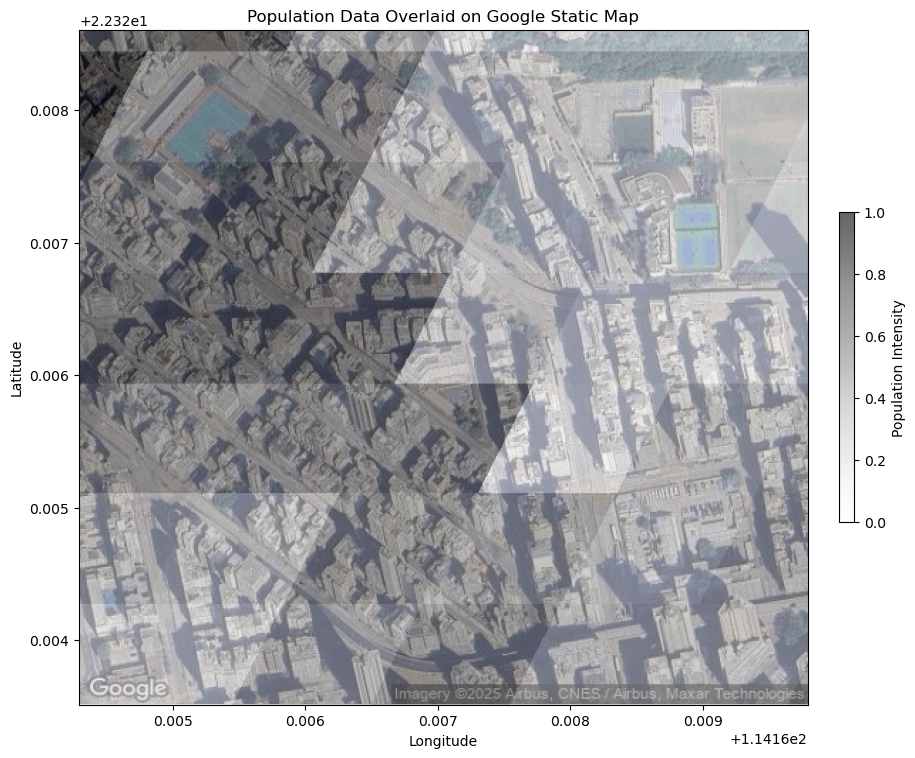

In [36]:
import ee
import os
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.enums import Resampling
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import requests
import math

# Initialize Earth Engine
ee.Initialize()

# Function to calculate bounding box
def get_bounding_box(lat, lon, zoom, width=512, height=512):
    """
    Calculate a bounding box with latitude-dependent scaling for a given center and zoom.

    Parameters:
    - lat, lon: Latitude and longitude of the center.
    - zoom: Zoom level for the map.
    - width, height: Dimensions of the map image in pixels.

    Returns:
    - min_lon, min_lat, max_lon, max_lat: Bounding box coordinates.
    """
    EARTH_RADIUS = 6378137.0
    INITIAL_RESOLUTION = 2 * math.pi * EARTH_RADIUS / 256.0  # Resolution at zoom 0
    origin_shift = 2 * math.pi * EARTH_RADIUS / 2.0

    resolution = INITIAL_RESOLUTION / (2 ** zoom)

    # Calculate meters per pixel for latitude and longitude
    mx = lon * origin_shift / 180.0
    my = math.log(math.tan((90 + lat) * math.pi / 360.0)) / (math.pi / 180.0)
    my = my * origin_shift / 180.0

    half_width = (width / 2.0) * resolution
    half_height = (height / 2.0) * resolution

    minx = mx - half_width
    maxx = mx + half_width
    miny = my - half_height
    maxy = my + half_height

    def meters_to_latlon(mx, my):
        lon = (mx / origin_shift) * 180.0
        lat = (my / origin_shift) * 180.0
        lat = 180 / math.pi * (2 * math.atan(math.exp(lat * math.pi / 180.0)) - math.pi / 2.0)
        return lat, lon

    min_lat, min_lon = meters_to_latlon(minx, miny)
    max_lat, max_lon = meters_to_latlon(maxx, maxy)

    return min_lon, min_lat, max_lon, max_lat

def get_square_bounding_box(lat, lon, zoom, width=512, height=512):
    """
    Calculate a square bounding box in physical dimensions (meters) for a given center and zoom.

    Parameters:
    - lat, lon: Latitude and longitude of the center.
    - zoom: Zoom level for the map.
    - width, height: Dimensions of the map image in pixels.

    Returns:
    - min_lon, min_lat, max_lon, max_lat: Bounding box coordinates.
    """
    EARTH_RADIUS = 6378137.0
    INITIAL_RESOLUTION = 2 * math.pi * EARTH_RADIUS / 256.0  # Resolution at zoom 0
    origin_shift = 2 * math.pi * EARTH_RADIUS / 2.0

    resolution = INITIAL_RESOLUTION / (2 ** zoom)

    # Calculate meters per pixel for latitude and longitude
    mx = lon * origin_shift / 180.0
    my = math.log(math.tan((90 + lat) * math.pi / 360.0)) / (math.pi / 180.0)
    my = my * origin_shift / 180.0

    half_size = (width / 2.0) * resolution  # Use the same size for width and height

    minx = mx - half_size
    maxx = mx + half_size
    miny = my - half_size
    maxy = my + half_size

    def meters_to_latlon(mx, my):
        lon = (mx / origin_shift) * 180.0
        lat = (my / origin_shift) * 180.0
        lat = 180 / math.pi * (2 * math.atan(math.exp(lat * math.pi / 180.0)) - math.pi / 2.0)
        return lat, lon

    min_lat, min_lon = meters_to_latlon(minx, miny)
    max_lat, max_lon = meters_to_latlon(maxx, maxy)

    return min_lon, min_lat, max_lon, max_lat


# Reproject GeoTIFF to EPSG:4326
def reproject_to_epsg4326(input_tiff, output_tiff):
    dst_crs = "EPSG:4326"
    with rasterio.open(input_tiff) as src:
        if str(src.crs) == dst_crs:
            print(f"The GeoTIFF is already in EPSG:4326. Skipping reprojection.")
            return input_tiff

        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update({
            "crs": dst_crs,
            "transform": transform,
            "width": width,
            "height": height,
        })

        with rasterio.open(output_tiff, "w", **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest,
                )
    print(f"Reprojected GeoTIFF saved to {output_tiff}")
    return output_tiff

# Download Google Static Map
def download_and_crop_static_map(api_key, lat, lon, zoom, output_file, timeout=10, max_retries=3):
    base_url = "https://maps.googleapis.com/maps/api/staticmap"
    params = {
        "center": f"{lat},{lon}",
        "zoom": zoom,
        "size": "512x512",
        "maptype": "satellite",
        "key": api_key,
    }

    for attempt in range(max_retries):
        try:
            response = requests.get(base_url, params=params, timeout=timeout)
            if response.status_code == 200:
                image = Image.open(BytesIO(response.content))
                image.save(output_file)
                print(f"Google Static Map saved to {output_file}")
                return True
        except Exception as e:
            print(f"Error on attempt {attempt + 1}: {e}")
    print(f"Failed to download map after {max_retries} attempts.")
    return False

def overlay_population_automated(lat, lon, zoom, size, api_key, output_image_file, output_tiff_file):
    """
    Automates the overlay of population data on a Google Static Map, ensuring square plots.

    Parameters:
    - lat, lon: Latitude and Longitude of the center.
    - zoom: Zoom level for the map.
    - size: Size of the Google Static Map in pixels (width and height).
    - api_key: Google Maps API key.
    - output_image_file: Path to save the Google Static Map image.
    - output_tiff_file: Path to save the population GeoTIFF.
    """
    # Step 1: Download the GHSL population TIFF
    ghsl_tif_file = download_ghsl_tiff(lat, lon, zoom, size, output_tiff_file)

    # Step 2: Reproject the TIFF to EPSG:4326 if necessary
    reprojected_tiff_file = output_tiff_file.replace(".tiff", "_reprojected.tiff")
    ghsl_tif_file = reproject_to_epsg4326(ghsl_tif_file, reprojected_tiff_file)

    # Step 3: Calculate bounding box using the get_bounding_box function
    bbox = get_bounding_box(lat, lon, zoom, width=size, height=size)
    min_lon, min_lat, max_lon, max_lat = bbox
    print(f"Bounding Box: {bbox}")

    # Step 4: Download Google Static Map
    success = download_and_crop_static_map(api_key, lat, lon, zoom, output_image_file)
    if not success:
        return

    # Step 5: Open the Google Map image
    google_map = Image.open(output_image_file)

    # Step 6: Read the reprojected population GeoTIFF
    with rasterio.open(ghsl_tif_file) as src:
        population_data = src.read(1)
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)

    # Normalize population data
    normalized_population = (population_data - np.min(population_data)) / (
        np.max(population_data) - np.min(population_data)
    )

    # Step 7: Plot and overlay the population data
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(google_map, extent=(min_lon, max_lon, min_lat, max_lat), zorder=1)

    # Overlay normalized population data
    img = ax.imshow(
        normalized_population,
        cmap="Greys",
        alpha=0.6,
        extent=extent,
        zorder=2,
    )

    # Add colorbar for population intensity
    cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)
    cbar.set_label("Population Intensity")

    # Ensure square aspect ratio
    ax.set_aspect('equal', adjustable='box')

    ax.set_title("Population Data Overlaid on Google Static Map")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # Save the overlay image
    overlay_output_file = output_image_file.replace(".png", "_overlay.png")
    plt.savefig(overlay_output_file, dpi=600, bbox_inches="tight")
    print(f"Overlay image saved to {overlay_output_file}")
    plt.show()


# Example Usage
api_key =   # Replace with your Google Maps API key
lat, lon =  22.32606067545809, 114.16704408356823  # Center coordinates
zoom = 17
size = 512  # Image size in pixels
output_image_file = "/Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/images/example_hk_google_static_map.png"
output_tiff_file = "/Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/dataset/GGSL_POP/example_hk_normalized_population.tiff"

# Call the function
overlay_population_automated(lat, lon, zoom, size, api_key, output_image_file, output_tiff_file)


# Switzerland

Download URL: https://earthengine.googleapis.com/v1/projects/earthengine-legacy/thumbnails/f698cca140f538ed2d563e677fbd12ee-4665672e9f39fb772b31f1894c3d783e:getPixels
GeoTIFF downloaded as '/Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/dataset/GGSL_POP/sw_normalized_population.tiff'
The GeoTIFF is already in EPSG:4326. Skipping reprojection.
Bounding Box: (8.500122045873699, 47.37836691391428, 8.505615209936199, 47.3820864998913)
Google Static Map saved to /Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/images/switzerland/google_static_map.png
Normalized population data saved to /Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/dataset/GGSL_POP/sw_normalized_population.tiff
Overlay image saved to /Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/images/switzerland/google_static_map_overlay.png


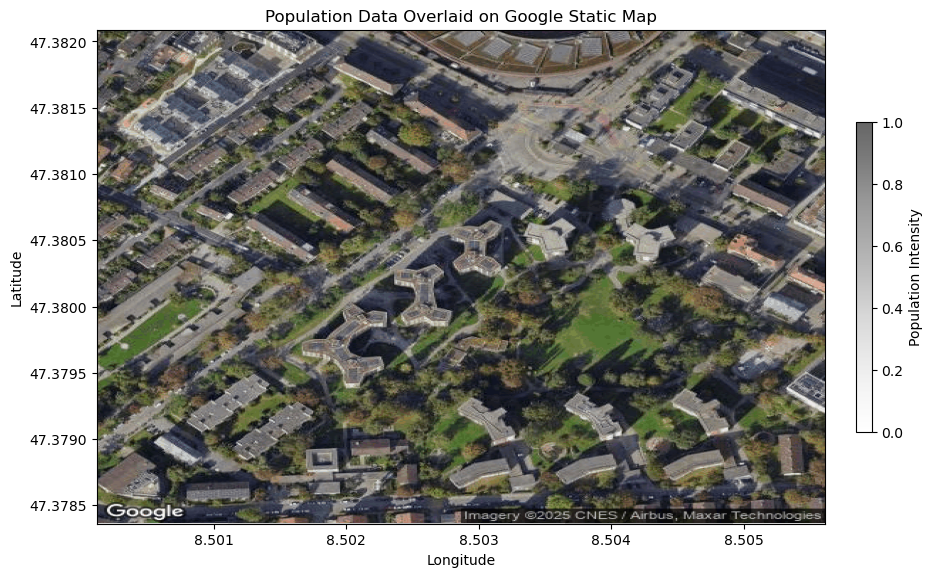

In [16]:
import ee
import os

# Initialize Earth Engine
ee.Initialize()

def download_ghsl_tiff(lat, lon, zoom, size, output_tiff_file):
    """Download the GHSL population GeoTIFF for a specific bounding box."""
    # Calculate bounding box
    bbox = get_bounding_box(lat, lon, zoom, size)
    region = ee.Geometry.Rectangle([bbox[0], bbox[1], bbox[2], bbox[3]])

    # Load the GHSL dataset
    ghsl_dataset = ee.ImageCollection("JRC/GHSL/P2023A/GHS_POP").filterBounds(region)
    ghsl_image = ghsl_dataset.filterDate('2020-01-01', '2020-12-31').mean()

    # Clip the image to the bounding box
    ghsl_cropped = ghsl_image.clip(region)

    # Generate download URL
    url = ghsl_cropped.getDownloadURL({
        'scale': 1,  # Match pixel size (e.g., 1 meter per pixel)
        'region': region.getInfo()['coordinates'],
        'format': 'GeoTIFF'
    })
    print(f"Download URL: {url}")

    # Download and save the file
    response = requests.get(url, stream=True)
    with open(output_tiff_file, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print(f"GeoTIFF downloaded as '{output_tiff_file}'")

    return output_tiff_file

from rasterio.warp import calculate_default_transform, reproject, Resampling

def reproject_to_epsg4326(input_tiff, output_tiff):
    """
    Reproject a GeoTIFF to EPSG:4326 if it is not already in that CRS.
    """
    dst_crs = "EPSG:4326"
    with rasterio.open(input_tiff) as src:
        if str(src.crs) == dst_crs:  # Skip reprojection if already in EPSG:4326
            print(f"The GeoTIFF is already in EPSG:4326. Skipping reprojection.")
            return input_tiff

        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update({
            "crs": dst_crs,
            "transform": transform,
            "width": width,
            "height": height,
        })

        with rasterio.open(output_tiff, "w", **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest,
                )
    print(f"Reprojected GeoTIFF saved to {output_tiff}")
    return output_tiff


def overlay_population_and_save(lat, lon, zoom, size, api_key, output_image_file, output_tiff_file):
    """
    Overlay population data dynamically downloaded from GHSL on Google Static Map.
    """
    # Step 1: Download the GHSL population TIFF
    ghsl_tif_file = download_ghsl_tiff(lat, lon, zoom, size, output_tiff_file)

    # Step 2: Reproject the TIFF to EPSG:4326 if necessary
    reprojected_tiff_file = output_tiff_file.replace(".tiff", "_reprojected.tiff")
    ghsl_tif_file = reproject_to_epsg4326(ghsl_tif_file, reprojected_tiff_file)

    # Step 3: Calculate bounding box
    bbox = get_bounding_box(lat, lon, zoom)
    min_lon, min_lat, max_lon, max_lat = bbox
    print(f"Bounding Box: {bbox}")

    # Step 4: Download Google Static Map
    success = download_and_crop_static_map(api_key, lat, lon, zoom, output_image_file)
    if not success:
        return

    # Step 5: Open the Google Map image
    google_map = Image.open(output_image_file)

    # Step 6: Read the reprojected GHSL population GeoTIFF
    with rasterio.open(ghsl_tif_file) as src:
        population_data = src.read(1)  # Assuming population data is in the first band
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)

    # Normalize the population data for better visualization
    normalized_population = (population_data - np.min(population_data)) / (np.max(population_data) - np.min(population_data))

    # Save the normalized population data as a new TIFF
    with rasterio.open(output_tiff_file, 'w', **src.meta) as dst:
        dst.write(normalized_population, 1)
    print(f"Normalized population data saved to {output_tiff_file}")

    # Step 7: Plot and overlay the population data
    fig, ax = plt.subplots(figsize=(10, 10))
    # Show Google Map
    ax.imshow(google_map, extent=(min_lon, max_lon, min_lat, max_lat), zorder=1)

    # Overlay population data with transparency (alpha)
    img = ax.imshow(
        normalized_population,
        cmap="Greys",  # You can change the colormap if needed
        alpha=0.6,  # Adjust transparency
        extent=extent,
        zorder=2,
    )

    # Add a colorbar for population intensity
    cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)
    cbar.set_label("Population Intensity")

    ax.set_title("Population Data Overlaid on Google Static Map")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # Save the combined overlay image
    overlay_output_file = output_image_file.replace(".png", "_overlay.png")
    plt.savefig(overlay_output_file, dpi=600, bbox_inches="tight")
    print(f"Overlay image saved to {overlay_output_file}")
    plt.show()






# Example Usage
api_key =   # Replace with your Google Maps API key
lat, lon =  47.380226739704895, 8.502868627904947  # Center coordinates
zoom = 17
size = 512  # Image size in pixels
output_image_file = "/Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/images/switzerland/google_static_map.png"
output_tiff_file = "/Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/dataset/GGSL_POP/sw_normalized_population.tiff"


# Call the function
overlay_population_and_save(lat, lon, zoom, size, api_key, output_image_file, output_tiff_file)


Download URL: https://earthengine.googleapis.com/v1/projects/earthengine-legacy/thumbnails/2a30d813fcb7f49b21eb3713173a8748-c7c9679f6389ae2e082efeb775f0d809:getPixels
GeoTIFF downloaded as '/Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/dataset/GGSL_POP/uk_normalized_population.tiff'
The GeoTIFF is already in EPSG:4326. Skipping reprojection.
Bounding Box: (-0.19661134514471104, 51.480396092062165, -0.19111818108221107, 51.48381700949806)
Google Static Map saved to /Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/images/uk/google_static_map.png
Overlay image saved to /Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/images/uk/google_static_map_overlay.png


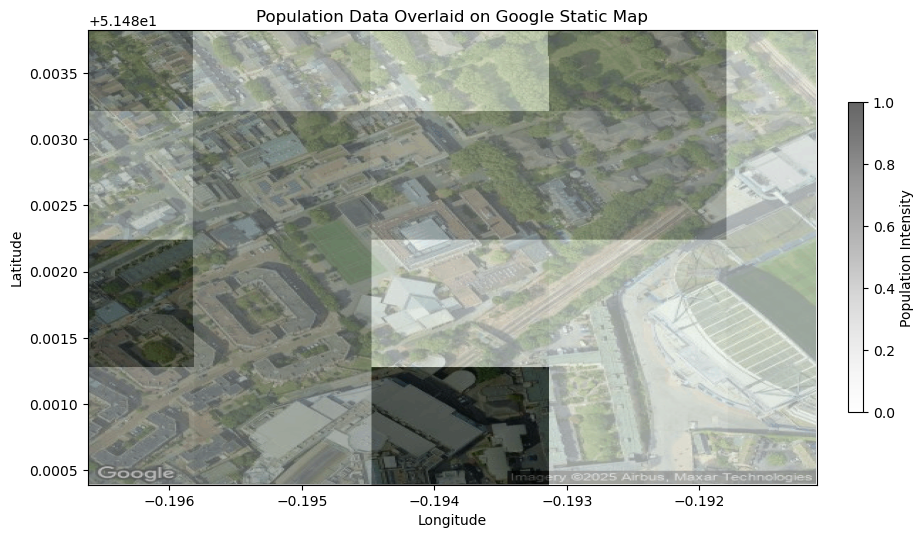

In [35]:
import ee
import os
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.enums import Resampling
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import requests
import math

# Initialize Earth Engine
ee.Initialize()

# Function to calculate bounding box
def get_bounding_box(lat, lon, zoom, width=512, height=512):
    """
    Calculate a bounding box with latitude-dependent scaling for a given center and zoom.

    Parameters:
    - lat, lon: Latitude and longitude of the center.
    - zoom: Zoom level for the map.
    - width, height: Dimensions of the map image in pixels.

    Returns:
    - min_lon, min_lat, max_lon, max_lat: Bounding box coordinates.
    """
    EARTH_RADIUS = 6378137.0
    INITIAL_RESOLUTION = 2 * math.pi * EARTH_RADIUS / 256.0  # Resolution at zoom 0
    origin_shift = 2 * math.pi * EARTH_RADIUS / 2.0

    resolution = INITIAL_RESOLUTION / (2 ** zoom)

    # Calculate meters per pixel for latitude and longitude
    mx = lon * origin_shift / 180.0
    my = math.log(math.tan((90 + lat) * math.pi / 360.0)) / (math.pi / 180.0)
    my = my * origin_shift / 180.0

    half_width = (width / 2.0) * resolution
    half_height = (height / 2.0) * resolution

    minx = mx - half_width
    maxx = mx + half_width
    miny = my - half_height
    maxy = my + half_height

    def meters_to_latlon(mx, my):
        lon = (mx / origin_shift) * 180.0
        lat = (my / origin_shift) * 180.0
        lat = 180 / math.pi * (2 * math.atan(math.exp(lat * math.pi / 180.0)) - math.pi / 2.0)
        return lat, lon

    min_lat, min_lon = meters_to_latlon(minx, miny)
    max_lat, max_lon = meters_to_latlon(maxx, maxy)

    return min_lon, min_lat, max_lon, max_lat

def get_square_bounding_box(lat, lon, zoom, width=512, height=512):
    """
    Calculate a square bounding box in physical dimensions (meters) for a given center and zoom.

    Parameters:
    - lat, lon: Latitude and longitude of the center.
    - zoom: Zoom level for the map.
    - width, height: Dimensions of the map image in pixels.

    Returns:
    - min_lon, min_lat, max_lon, max_lat: Bounding box coordinates.
    """
    EARTH_RADIUS = 6378137.0
    INITIAL_RESOLUTION = 2 * math.pi * EARTH_RADIUS / 256.0  # Resolution at zoom 0
    origin_shift = 2 * math.pi * EARTH_RADIUS / 2.0

    resolution = INITIAL_RESOLUTION / (2 ** zoom)

    # Calculate meters per pixel for latitude and longitude
    mx = lon * origin_shift / 180.0
    my = math.log(math.tan((90 + lat) * math.pi / 360.0)) / (math.pi / 180.0)
    my = my * origin_shift / 180.0

    half_size = (width / 2.0) * resolution  # Use the same size for width and height

    minx = mx - half_size
    maxx = mx + half_size
    miny = my - half_size
    maxy = my + half_size

    def meters_to_latlon(mx, my):
        lon = (mx / origin_shift) * 180.0
        lat = (my / origin_shift) * 180.0
        lat = 180 / math.pi * (2 * math.atan(math.exp(lat * math.pi / 180.0)) - math.pi / 2.0)
        return lat, lon

    min_lat, min_lon = meters_to_latlon(minx, miny)
    max_lat, max_lon = meters_to_latlon(maxx, maxy)

    return min_lon, min_lat, max_lon, max_lat


# Reproject GeoTIFF to EPSG:4326
def reproject_to_epsg4326(input_tiff, output_tiff):
    dst_crs = "EPSG:4326"
    with rasterio.open(input_tiff) as src:
        if str(src.crs) == dst_crs:
            print(f"The GeoTIFF is already in EPSG:4326. Skipping reprojection.")
            return input_tiff

        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update({
            "crs": dst_crs,
            "transform": transform,
            "width": width,
            "height": height,
        })

        with rasterio.open(output_tiff, "w", **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest,
                )
    print(f"Reprojected GeoTIFF saved to {output_tiff}")
    return output_tiff

# Download Google Static Map
def download_and_crop_static_map(api_key, lat, lon, zoom, output_file, timeout=10, max_retries=3):
    base_url = "https://maps.googleapis.com/maps/api/staticmap"
    params = {
        "center": f"{lat},{lon}",
        "zoom": zoom,
        "size": "512x512",
        "maptype": "satellite",
        "key": api_key,
    }

    for attempt in range(max_retries):
        try:
            response = requests.get(base_url, params=params, timeout=timeout)
            if response.status_code == 200:
                image = Image.open(BytesIO(response.content))
                image.save(output_file)
                print(f"Google Static Map saved to {output_file}")
                return True
        except Exception as e:
            print(f"Error on attempt {attempt + 1}: {e}")
    print(f"Failed to download map after {max_retries} attempts.")
    return False

def overlay_population_automated(lat, lon, zoom, size, api_key, output_image_file, output_tiff_file):
    """
    Automates the overlay of population data on a Google Static Map, ensuring square plots.

    Parameters:
    - lat, lon: Latitude and Longitude of the center.
    - zoom: Zoom level for the map.
    - size: Size of the Google Static Map in pixels (width and height).
    - api_key: Google Maps API key.
    - output_image_file: Path to save the Google Static Map image.
    - output_tiff_file: Path to save the population GeoTIFF.
    """
    # Step 1: Download the GHSL population TIFF
    ghsl_tif_file = download_ghsl_tiff(lat, lon, zoom, size, output_tiff_file)

    # Step 2: Reproject the TIFF to EPSG:4326 if necessary
    reprojected_tiff_file = output_tiff_file.replace(".tiff", "_reprojected.tiff")
    ghsl_tif_file = reproject_to_epsg4326(ghsl_tif_file, reprojected_tiff_file)

    # Step 3: Calculate bounding box using the get_bounding_box function
    bbox = get_bounding_box(lat, lon, zoom, width=size, height=size)
    min_lon, min_lat, max_lon, max_lat = bbox
    print(f"Bounding Box: {bbox}")

    # Step 4: Download Google Static Map
    success = download_and_crop_static_map(api_key, lat, lon, zoom, output_image_file)
    if not success:
        return

    # Step 5: Open the Google Map image
    google_map = Image.open(output_image_file)

    # Step 6: Read the reprojected population GeoTIFF
    with rasterio.open(ghsl_tif_file) as src:
        population_data = src.read(1)
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)

    # Normalize population data
    normalized_population = (population_data - np.min(population_data)) / (
        np.max(population_data) - np.min(population_data)
    )

    # Step 7: Plot and overlay the population data
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(google_map, extent=(min_lon, max_lon, min_lat, max_lat), zorder=1)

    # Overlay normalized population data
    img = ax.imshow(
        normalized_population,
        cmap="Greys",
        alpha=0.6,
        extent=extent,
        zorder=2,
    )

    # Add colorbar for population intensity
    cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)
    cbar.set_label("Population Intensity")

    # Ensure square aspect ratio
    ax.set_aspect('equal', adjustable='box')

    ax.set_title("Population Data Overlaid on Google Static Map")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # Save the overlay image
    overlay_output_file = output_image_file.replace(".png", "_overlay.png")
    plt.savefig(overlay_output_file, dpi=600, bbox_inches="tight")
    print(f"Overlay image saved to {overlay_output_file}")
    plt.show()


# Example Usage
api_key =  # Replace with your Google Maps API key
lat, lon =  51.48210658285678, -0.19386476311346104  # Center coordinates
zoom = 17
size = 512  # Image size in pixels
output_image_file = "/Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/images/uk/google_static_map.png"
output_tiff_file = "/Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/dataset/GGSL_POP/uk_normalized_population.tiff"

# Call the function
overlay_population_automated(lat, lon, zoom, size, api_key, output_image_file, output_tiff_file)


Google Static Map Bounding Box (EPSG:3857): -21733.80076911944, 6706867.095309625, -21428.052655978736, 6707172.843422766
Google Static Map saved to /Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/images/uk/google_static_map.png
Population Data Extent (Original CRS): (8.500047864548577, 8.50555453724023, 47.37835182694428, 47.382079835373375)
Population Data CRS: EPSG:4326
Reprojected Population Data Extent (EPSG:3857): (946221.0, 946833.9999999999, 6004050.872006799, 6004663.752749379)


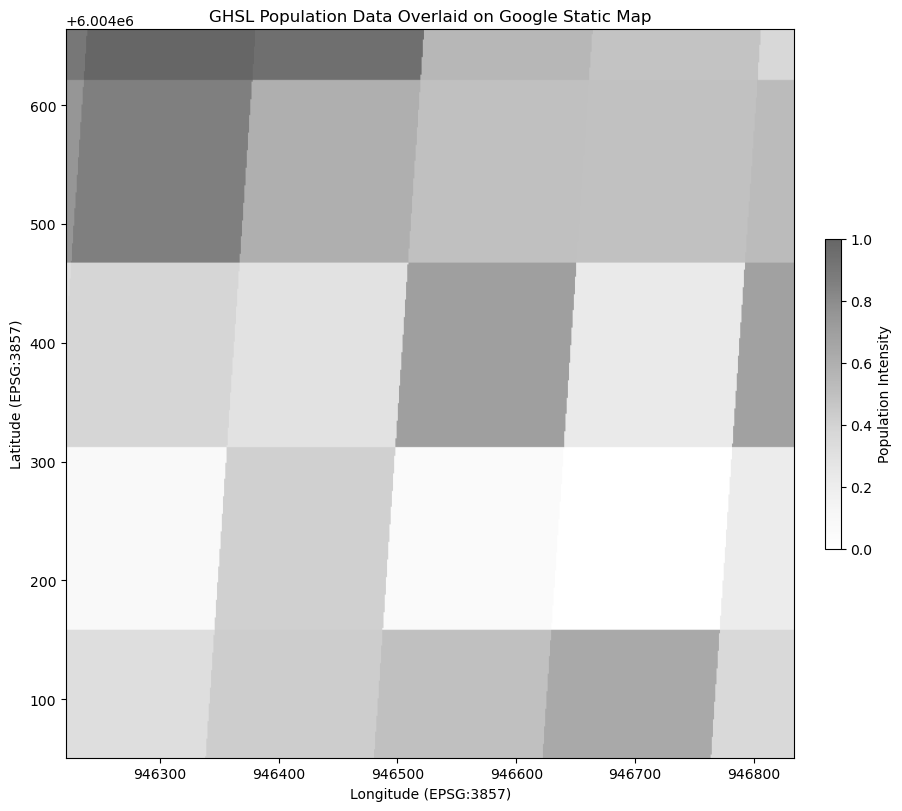

In [48]:
from pyproj import Transformer
import rasterio
def get_bounding_box(lat, lon, zoom, size=512):
    EARTH_RADIUS = 6378137.0
    INITIAL_RESOLUTION = 2 * np.pi * EARTH_RADIUS / 256.0
    origin_shift = 2 * np.pi * EARTH_RADIUS / 2.0

    resolution = INITIAL_RESOLUTION / (2 ** zoom)

    mx = lon * origin_shift / 180.0
    my = np.log(np.tan((90 + lat) * np.pi / 360.0)) / (np.pi / 180.0)
    my = my * origin_shift / 180.0

    half_size = (size / 2.0) * resolution
    minx = mx - half_size
    maxx = mx + half_size
    miny = my - half_size
    maxy = my + half_size

    def meters_to_latlon(mx, my):
        lon = (mx / origin_shift) * 180.0
        lat = (my / origin_shift) * 180.0
        lat = 180 / np.pi * (2 * np.arctan(np.exp(lat * np.pi / 180.0)) - np.pi / 2.0)
        return lat, lon

    min_lat, min_lon = meters_to_latlon(minx, miny)
    max_lat, max_lon = meters_to_latlon(maxx, maxy)

    return min_lon, min_lat, max_lon, max_lat
def reproject_ghsl_to_web_mercator(input_tiff, output_tiff):
    """
    Reproject GHSL GeoTIFF to EPSG:3857 for alignment with Google Maps.
    
    Parameters:
    - input_tiff: Path to the input GHSL GeoTIFF.
    - output_tiff: Path to save the reprojected GeoTIFF.
    
    Returns:
    - Path to the reprojected GeoTIFF.
    """
    dst_crs = "EPSG:3857"
    with rasterio.open(input_tiff) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update({
            "crs": dst_crs,
            "transform": transform,
            "width": width,
            "height": height,
        })

        with rasterio.open(output_tiff, "w", **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest,
                )
    print(f"Reprojected GeoTIFF saved to {output_tiff}")
    return output_tiff


def calculate_web_mercator_bbox(lat, lon, zoom, size):
    """
    Calculate the bounding box in EPSG:3857 for a Google Static Map.

    Parameters:
    - lat, lon: Center of the map in EPSG:4326 (latitude and longitude).
    - zoom: Zoom level of the map.
    - size: Size of the map in pixels (assumed square).

    Returns:
    - minx, miny, maxx, maxy: Bounding box in EPSG:3857 (meters).
    """
    EARTH_RADIUS = 6378137.0
    TILE_SIZE = 512  # Standard Google Maps tile size
    initial_resolution = 2 * math.pi * EARTH_RADIUS / TILE_SIZE
    resolution = initial_resolution / (2 ** zoom)

    # Convert the center point to EPSG:3857
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    center_x, center_y = transformer.transform(lon, lat)

    half_extent = (size / 2) * resolution
    minx = center_x - half_extent
    maxx = center_x + half_extent
    miny = center_y - half_extent
    maxy = center_y + half_extent

    return minx, miny, maxx, maxy



from pyproj import Transformer
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


def reproject_extent(extent, src_crs, dst_crs="EPSG:3857"):
    """
    Reproject the extent (bounding box) of a GeoTIFF from one CRS to another.

    Parameters:
    - extent: Tuple (minx, maxx, miny, maxy) in the source CRS.
    - src_crs: Source CRS as a string (e.g., "EPSG:4326").
    - dst_crs: Destination CRS as a string (default: "EPSG:3857").

    Returns:
    - Reprojected extent as (minx, maxx, miny, maxy) in the destination CRS.
    """
    transformer = Transformer.from_crs(src_crs, dst_crs, always_xy=True)
    minx, miny = transformer.transform(extent[0], extent[2])  # Bottom-left corner
    maxx, maxy = transformer.transform(extent[1], extent[3])  # Top-right corner
    return (minx, maxx, miny, maxy)


def overlay_ghsl_on_google_map(lat, lon, zoom, size, api_key, ghsl_tiff, output_image_file):
    """
    Overlay GHSL Population Data on a Google Static Map.
    """
    # Step 1: Calculate bounding box for Google Static Map
    minx, miny, maxx, maxy = calculate_web_mercator_bbox(lat, lon, zoom, size)
    print(f"Google Static Map Bounding Box (EPSG:3857): {minx}, {miny}, {maxx}, {maxy}")

    # Step 2: Download the Google Static Map
    success = download_and_crop_static_map(api_key, lat, lon, zoom, output_image_file)
    if not success:
        print("Failed to download Google Static Map.")
        return

    # Step 3: Load Population GeoTIFF and Reproject Extent
    with rasterio.open(ghsl_tiff) as src:
        population_crs = src.crs
        population_extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
        print(f"Population Data Extent (Original CRS): {population_extent}")
        print(f"Population Data CRS: {population_crs}")

        # Reproject Population Data Extent to EPSG:3857
        reprojected_extent = reproject_extent(population_extent, population_crs, "EPSG:3857")
        print(f"Reprojected Population Data Extent (EPSG:3857): {reprojected_extent}")

        # Read the Population Data
        population_data = src.read(1)

    # Normalize population data
    normalized_population = (population_data - np.min(population_data)) / (
        np.max(population_data) - np.min(population_data)
    )

    # Step 4: Plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot Google Map
    google_map = Image.open(output_image_file)
    ax.imshow(google_map, extent=(minx, maxx, miny, maxy), zorder=1)  # Google Map

    # Plot Population Data with Reprojected Extent
    img = ax.imshow(
        normalized_population,
        cmap="Greys",
        alpha=0.6,
        extent=reprojected_extent,  # Use reprojected extent
        zorder=2,
    )

    # Add Colorbar and Enforce Square Aspect Ratio
    cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)
    cbar.set_label("Population Intensity")
    ax.set_aspect("equal", adjustable="box")

    ax.set_title("GHSL Population Data Overlaid on Google Static Map")
    ax.set_xlabel("Longitude (EPSG:3857)")
    ax.set_ylabel("Latitude (EPSG:3857)")

    plt.show()




tiff_file = "/Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/dataset/GGSL_POP/sw_cropped_ghsl.tiff"

# Example Usage
api_key =  # Replace with your Google Maps API key
lat, lon =  51.48210658285678, -0.19386476311346104  # Center coordinates
zoom = 17
size = 512  # Image size in pixels
output_image_file = "/Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/images/uk/google_static_map.png"
output_tiff_file = "/Users/wangzhuoyulucas/Library/Mobile Documents/com~apple~CloudDocs/SMART/dataset/GGSL_POP/uk_normalized_population.tiff"

# Call the function
overlay_ghsl_on_google_map(lat, lon, zoom, size, api_key, tiff_file, output_image_file)

In [51]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

def reproject_to_epsg3857(input_tiff, output_tiff):
    """
    Reproject GeoTIFF to EPSG:3857.
    """
    dst_crs = "EPSG:3857"
    with rasterio.open(input_tiff) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update({
            "crs": dst_crs,
            "transform": transform,
            "width": width,
            "height": height,
        })

        with rasterio.open(output_tiff, "w", **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest,
                )
    print(f"Reprojected GeoTIFF saved to {output_tiff}")
    return output_tiff


Google Static Map saved to /Users/wangzhuoyulucas/SMART /images/google_static_map.png
Population density TIFF downloaded to /Users/wangzhuoyulucas/SMART /images/population_density.tiff
Cropped GeoTIFF saved to /Users/wangzhuoyulucas/SMART /images/cropped_population_density.tiff
Overlay plot saved to /Users/wangzhuoyulucas/SMART /images/output_overlay_plot.png


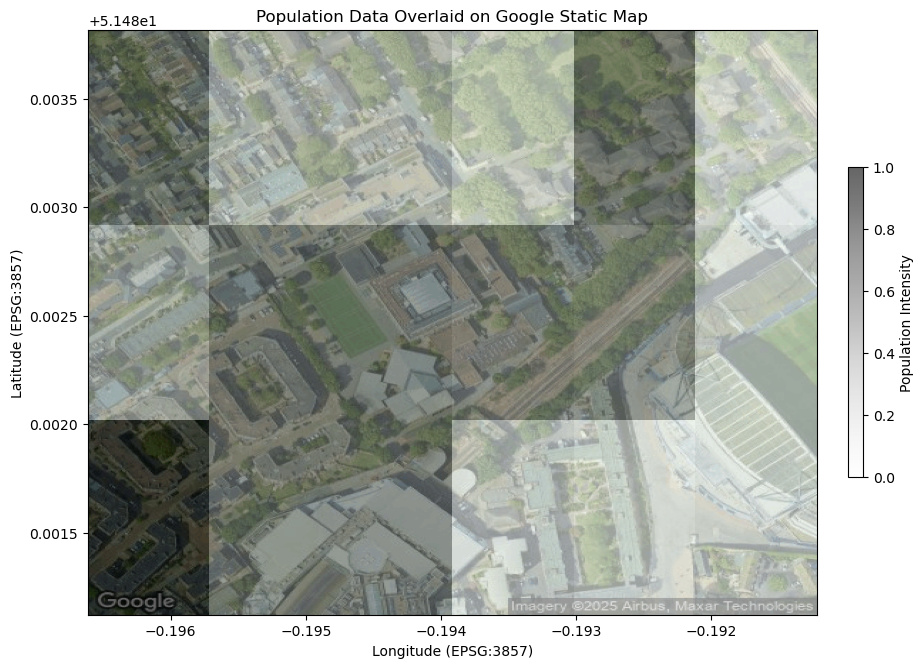

In [67]:
import math
import requests
import rasterio
from rasterio.windows import from_bounds
from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import Transformer
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Initialize Earth Engine (ensure you have `earthengine-api` installed and authenticated)
import ee
ee.Initialize()


# Function to calculate bounding box in EPSG:4326
def calculate_bounding_box(lat, lon, zoom, size):
    """
    Calculate the bounding box in EPSG:4326 for a Google Static Map.
    """
    EARTH_RADIUS = 6378137.0  # Earth's radius in meters
    TILE_SIZE = 256
    initial_resolution = 2 * math.pi * EARTH_RADIUS / TILE_SIZE
    resolution = initial_resolution / (2 ** zoom)

    half_extent = (size / 2.0) * resolution  # Extent in meters

    # Convert center to Web Mercator (EPSG:3857)
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    center_x, center_y = transformer.transform(lon, lat)

    # Calculate bounding box in Web Mercator
    minx = center_x - half_extent
    maxx = center_x + half_extent
    miny = center_y - half_extent
    maxy = center_y + half_extent

    # Convert back to latitude/longitude (EPSG:4326)
    transformer_back = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)
    min_lon, min_lat = transformer_back.transform(minx, miny)
    max_lon, max_lat = transformer_back.transform(maxx, maxy)

    return (min_lon, min_lat, max_lon, max_lat)


# Function to download Google Static Map
def download_google_static_map(api_key, lat, lon, zoom, size, output_image_file):
    """
    Download Google Static Map for a given location and save it as an image.
    """
    base_url = "https://maps.googleapis.com/maps/api/staticmap"
    params = {
        "center": f"{lat},{lon}",
        "zoom": zoom,
        "size": f"{size}x{size}",
        "maptype": "satellite",
        "key": api_key,
    }

    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        with open(output_image_file, "wb") as f:
            f.write(response.content)
        print(f"Google Static Map saved to {output_image_file}")
    else:
        print("Failed to download Google Static Map:", response.content)


# Function to download GHSL Population Density GeoTIFF
def download_population_tiff(lat, lon, zoom, output_tiff_file):
    """
    Download GHSL population density GeoTIFF from Earth Engine for a given bounding box.
    """
    # Calculate bounding box
    bbox = calculate_bounding_box(lat, lon, zoom, 512)
    min_lon, min_lat, max_lon, max_lat = bbox

    # Define region in Earth Engine
    region = ee.Geometry.Rectangle([min_lon, min_lat, max_lon, max_lat])

    # GHSL dataset
    ghsl_dataset = ee.ImageCollection("JRC/GHSL/P2023A/GHS_POP").filterBounds(region)

    # Select population data (e.g., 2020)
    ghsl_image = ghsl_dataset.filterDate('2020-01-01', '2020-12-31').mean()
    ghsl_cropped = ghsl_image.clip(region)

    # Download URL
    url = ghsl_cropped.getDownloadURL({
        'scale': 100,
        'region': region.getInfo()['coordinates'],
        'format': 'GeoTIFF'
    })

    # Download the GeoTIFF
    response = requests.get(url, stream=True)
    with open(output_tiff_file, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"Population density TIFF downloaded to {output_tiff_file}")
    return output_tiff_file


# Function to crop GeoTIFF to bounding box
from rasterio.windows import from_bounds

def crop_geotiff_to_bbox(input_tiff, output_tiff, bbox):
    """
    Crop a GeoTIFF to the given bounding box (in EPSG:4326).

    Parameters:
    - input_tiff: Path to the input GeoTIFF.
    - output_tiff: Path to save the cropped GeoTIFF.
    - bbox: (min_lon, min_lat, max_lon, max_lat) in EPSG:4326.
    """
    with rasterio.open(input_tiff) as src:
        # Create a window using the bounding box
        window = from_bounds(
            left=bbox[0], bottom=bbox[1], right=bbox[2], top=bbox[3], transform=src.transform
        )
        transform = src.window_transform(window)

        # Update metadata for cropped GeoTIFF
        kwargs = src.meta.copy()
        kwargs.update({
            "height": window.height,
            "width": window.width,
            "transform": transform,
        })

        # Write cropped GeoTIFF
        with rasterio.open(output_tiff, "w", **kwargs) as dst:
            dst.write(src.read(window=window))
    print(f"Cropped GeoTIFF saved to {output_tiff}")



# Function to plot population data with Google Map
def plot_population_with_google_map_dynamic(lat, population_tiff, google_map_file, output_plot_file):
    """
    Plot population data overlaid on Google Static Map with dynamic latitude scaling.
    """
    # Load Google Map image
    google_map = Image.open(google_map_file)

    # Load Population GeoTIFF
    with rasterio.open(population_tiff) as src:
        population_data = src.read(1)
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)

    # Normalize population data
    normalized_population = (population_data - np.min(population_data)) / (
        np.max(population_data) - np.min(population_data)
    )

    # Calculate latitude scaling factor
    lat_scaling = math.cos(math.radians(lat))

    # Adjust aspect ratio
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(google_map, extent=extent, zorder=1)
    img = ax.imshow(normalized_population, cmap="Greys", alpha=0.6, extent=extent, zorder=2)

    # Add colorbar
    cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)
    cbar.set_label("Population Intensity")

    # Dynamically adjust aspect ratio with latitude scaling
    ax.set_aspect(1 / lat_scaling, adjustable="box")

    ax.set_title("Population Data Overlaid on Google Static Map")
    ax.set_xlabel("Longitude (EPSG:3857)")
    ax.set_ylabel("Latitude (EPSG:3857)")

    # Save plot
    plt.savefig(output_plot_file, dpi=300, bbox_inches="tight")
    print(f"Overlay plot saved to {output_plot_file}")
    plt.show()




# Main Workflow
api_key =   # Replace with your Google Maps API key
lat, lon =  51.48210658285678, -0.19386476311346104  # Ce
zoom = 17
size = 512


# File paths
population_tiff = "/Users/wangzhuoyulucas/SMART /images/population_density.tiff"
cropped_tiff = "/Users/wangzhuoyulucas/SMART /images/cropped_population_density.tiff"
google_map_file = "/Users/wangzhuoyulucas/SMART /images/google_static_map.png"
output_plot_file = "/Users/wangzhuoyulucas/SMART /images/output_overlay_plot.png"

# Workflow
bbox = calculate_bounding_box(lat, lon, zoom, size)
download_google_static_map(api_key, lat, lon, zoom, size, google_map_file)
download_population_tiff(lat, lon, zoom, population_tiff)
crop_geotiff_to_bbox(population_tiff, cropped_tiff, bbox)
plot_population_with_google_map_dynamic(lat, cropped_tiff, google_map_file, output_plot_file)


# SQUARE PLOT

In [3]:
import ee
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
import rasterio
from rasterio.enums import Resampling
from io import BytesIO
from matplotlib import cm

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Function to calculate bounding box
def get_bounding_box(lat, lon, zoom, size=512):
    EARTH_RADIUS = 6378137.0
    INITIAL_RESOLUTION = 2 * np.pi * EARTH_RADIUS / 256.0
    origin_shift = 2 * np.pi * EARTH_RADIUS / 2.0

    resolution = INITIAL_RESOLUTION / (2 ** zoom)
    mx = lon * origin_shift / 180.0
    my = np.log(np.tan((90 + lat) * np.pi / 360.0)) / (np.pi / 180.0)
    my = my * origin_shift / 180.0

    half_size = (size / 2.0) * resolution
    minx = mx - half_size
    maxx = mx + half_size
    miny = my - half_size
    maxy = my + half_size

    def meters_to_latlon(mx, my):
        lon = (mx / origin_shift) * 180.0
        lat = (my / origin_shift) * 180.0
        lat = 180 / np.pi * (2 * np.arctan(np.exp(lat * np.pi / 180.0)) - np.pi / 2.0)
        return lat, lon

    min_lat, min_lon = meters_to_latlon(minx, miny)
    max_lat, max_lon = meters_to_latlon(maxx, maxy)
    return min_lon, min_lat, max_lon, max_lat

# Function to download Google Static Map
def download_google_static_map(api_key, lat, lon, zoom, size, output_image_file):
    """
    Download Google Static Map for a given location and save it as an image.
    """
    base_url = "https://maps.googleapis.com/maps/api/staticmap"
    params = {
        "center": f"{lat},{lon}",
        "zoom": zoom,
        "size": f"{size}x{size}",
        "maptype": "satellite",
        "key": api_key,
    }

    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        with open(output_image_file, "wb") as f:
            f.write(response.content)
        print(f"Google Static Map saved to {output_image_file}")
    else:
        print("Failed to download Google Static Map:", response.content)



# Resample GeoTIFF to desired dimensions
def resample_tiff_to_size(src_path, dst_size):
    with rasterio.open(src_path) as src:
        data = src.read(
            1,  # First band
            out_shape=(dst_size[1], dst_size[0])  # New height, width
        )
        transform = src.transform * src.transform.scale(
            (src.width / dst_size[0]),
            (src.height / dst_size[1])
        )
    return data, transform

# Apply colormap to GeoTIFF data
def apply_colormap(band, alpha=0.6):
    normalized_band = (band - np.min(band)) / (np.max(band) - np.min(band))
    colormap = cm.viridis(normalized_band)  # Use viridis colormap
    colormap[:, :, -1] = alpha  # Set transparency
    return (colormap * 255).astype(np.uint8)



# Parameters
lat, lon = 51.48210658285678, -0.19386476311346104
zoom = 17
size = 512

api_key = 
output_tiff = "/Users/wangzhuoyulucas/SMART /images/population_density.tiff"
map = "/Users/wangzhuoyulucas/SMART /images/google_static_map.png"

# Calculate bounding box
bbox = get_bounding_box(lat, lon, zoom, size)
region = ee.Geometry.Rectangle([bbox[0], bbox[1], bbox[2], bbox[3]])

# Fetch GeoTIFF from Earth Engine
ghsl_dataset = ee.ImageCollection("JRC/GHSL/P2023A/GHS_POP").filterBounds(region)
ghsl_image = ghsl_dataset.filterDate('2020-01-01', '2020-12-31').mean()
ghsl_cropped = ghsl_image.clip(region)
url = ghsl_cropped.getDownloadURL({
    'scale': 30,
    'region': region.getInfo()['coordinates'],
    'format': 'GeoTIFF'
})

# Download GeoTIFF
response = requests.get(url, stream=True)
with open(output_tiff, "wb") as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)

# Resample GeoTIFF
resampled_band, resampled_transform = resample_tiff_to_size(output_tiff, (512, 512))

# Fetch Google Map image
download_google_static_map(api_key, lat, lon, zoom, size, map)

google_map_image = Image.open(map)
# Apply colormap and transparency
colored_overlay = Image.fromarray(apply_colormap(resampled_band))
overlay_image = Image.alpha_composite(
    google_map_image.convert("RGBA"), colored_overlay.convert("RGBA")
)

# Display and save the final image
overlay_image.show()
overlay_image.save("/Users/wangzhuoyulucas/SMART /images/output_overlay_plot.png")


Google Static Map saved to /Users/wangzhuoyulucas/SMART /images/google_static_map.png


In [4]:
import ee
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
import rasterio
from rasterio.enums import Resampling
from io import BytesIO
from matplotlib import cm

class GeoDataProcessor:
    def __init__(self, api_key):
        self.api_key = api_key
        ee.Authenticate()
        ee.Initialize()

    def get_bounding_box(self, lat, lon, zoom, size=512):
        EARTH_RADIUS = 6378137.0
        INITIAL_RESOLUTION = 2 * np.pi * EARTH_RADIUS / 256.0
        origin_shift = 2 * np.pi * EARTH_RADIUS / 2.0

        resolution = INITIAL_RESOLUTION / (2 ** zoom)
        mx = lon * origin_shift / 180.0
        my = np.log(np.tan((90 + lat) * np.pi / 360.0)) / (np.pi / 180.0)
        my = my * origin_shift / 180.0

        half_size = (size / 2.0) * resolution
        minx = mx - half_size
        maxx = mx + half_size
        miny = my - half_size
        maxy = my + half_size

        def meters_to_latlon(mx, my):
            lon = (mx / origin_shift) * 180.0
            lat = (my / origin_shift) * 180.0
            lat = 180 / np.pi * (2 * np.arctan(np.exp(lat * np.pi / 180.0)) - np.pi / 2.0)
            return lat, lon

        min_lat, min_lon = meters_to_latlon(minx, miny)
        max_lat, max_lon = meters_to_latlon(maxx, maxy)
        return min_lon, min_lat, max_lon, max_lat

    # Function to download Google Static Map
    def download_google_static_map(api_key, lat, lon, zoom, size, output_image_file):
        """
        Download Google Static Map for a given location and save it as an image.
        """
        base_url = "https://maps.googleapis.com/maps/api/staticmap"
        params = {
            "center": f"{lat},{lon}",
            "zoom": zoom,
            "size": f"{size}x{size}",
            "maptype": "satellite",
            "key": api_key,
        }

        response = requests.get(base_url, params=params)
        if response.status_code == 200:
            with open(output_image_file, "wb") as f:
                f.write(response.content)
                print(f"Google Static Map saved to {output_image_file}")
        else:
            print("Failed to download Google Static Map:", response.content)
    

    def resample_tiff_to_size(self, src_path, dst_size):
        with rasterio.open(src_path) as src:
            data = src.read(
                1,  # First band
                out_shape=(dst_size[1], dst_size[0])  # New height, width
            )
            transform = src.transform * src.transform.scale(
                (src.width / dst_size[0]),
                (src.height / dst_size[1])
            )
        return data, transform

    def apply_colormap(self, band, alpha=0.6):
        normalized_band = (band - np.min(band)) / (np.max(band) - np.min(band))
        colormap = cm.viridis(normalized_band)
        colormap[:, :, -1] = alpha  # Set transparency
        return (colormap * 255).astype(np.uint8)

    def process_data(self, lat, lon, zoom, size, tiff_output, google_map_output, final_output):
        # Calculate bounding box
        bbox = self.get_bounding_box(lat, lon, zoom, size)
        region = ee.Geometry.Rectangle([bbox[0], bbox[1], bbox[2], bbox[3]])

        # Fetch GeoTIFF from Earth Engine
        ghsl_dataset = ee.ImageCollection("JRC/GHSL/P2023A/GHS_POP").filterBounds(region)
        ghsl_image = ghsl_dataset.filterDate('2020-01-01', '2020-12-31').mean()
        ghsl_cropped = ghsl_image.clip(region)
        url = ghsl_cropped.getDownloadURL({
            'scale': 30,
            'region': region.getInfo()['coordinates'],
            'format': 'GeoTIFF'
        })

        # Download GeoTIFF
        response = requests.get(url, stream=True)
        with open(tiff_output, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)

        # Resample GeoTIFF
        resampled_band, _ = self.resample_tiff_to_size(tiff_output, (size, size))

        # Fetch Google Map image
        self.download_google_static_map(lat, lon, zoom, size, google_map_output)

        google_map_image = Image.open(google_map_output)
        
        # Apply colormap and transparency
        colored_overlay = Image.fromarray(self.apply_colormap(resampled_band))
        overlay_image = Image.alpha_composite(
            google_map_image.convert("RGBA"), colored_overlay.convert("RGBA")
        )

        # Save the final image
        overlay_image.save(final_output)
        overlay_image.show()

# Example usage
if __name__ == "__main__":
    api_key =  
    lat, lon = 51.48210658285678, -0.19386476311346104
    zoom = 17
    size = 512

    processor = GeoDataProcessor(api_key)
    processor.process_data(
        lat,
        lon,
        zoom,
        size,
        "/Users/wangzhuoyulucas/SMART /images/population_density.tiff",
        "/Users/wangzhuoyulucas/SMART /images/google_static_map.png",
        "/Users/wangzhuoyulucas/SMART /images/output_overlay_plot.png"
    )


Failed to download Google Static Map: b'The Google Maps Platform server rejected your request. The provided API key is invalid. '
